<a href="https://colab.research.google.com/github/staerkjoe/ML_colab/blob/main/VisualTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 images are 32×32, but ViTs expect 224×224,

We also normalize with ImageNet stats (since ViTs are usually pretrained on ImageNet).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Preprocessing: resize to 224x224, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),     # ViT expects larger images (pretrained on ImageNet 224x224)
    transforms.ToTensor(),             # convert PIL → tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # represent the average and spread of pixel intensities across the ImageNet dataset
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # smaller batch size for faster training
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



Hugging Face Transformers library

Why:
- Pretrained weights let us leverage ImageNet knowledge.
- We replace the classification head to output 10 classes instead of 1000.

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load pretrained ViT (base model, patch size 16, pretrained on ImageNet-21k)
model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-tiny-patch16-224",
    num_labels=10,   # CIFAR-10 has 10 classes
    ignore_mismatched_sizes=True
)
# more spped in traning
model.vit.encoder.layer = model.vit.encoder.layer[:6] # keep only the first 6 layers instead of all 12 for more speed in training (forward pass)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermediat

This is essentially a trade-off:
- Full depth → better accuracy, slower training.
- Reduced depth → faster training, but maybe lower accuracy.

In [ ]:
# Freeze all layers except classification head for backprop
for param in model.vit.parameters():
    param.requires_grad = False

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer: AdamW (used in Transformer training)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01) # The “W” = decoupled weight decay → helps regularization and prevents overfitting
# weight decay discourages overly large weights

# Learning rate schedule (linear decay with warmup)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: min((step+1)/500, 1.0) * (1 - step/num_training_steps)
)

criterion = nn.CrossEntropyLoss()


LR scheduler:
- (step+1)/500 = warmup → gradually increase LR from 0 up to 1.0 over the first 500 steps.
  - This prevents the model from “diverging” early when weights are random.
- 1 - step/num_training_steps = linear decay → gradually decrease LR from full LR to 0 as training progresses.

In [ ]:
'''
Every batch: forward → loss → backpropagation → update weights.
Track how well model predicts correct labels.
Returns: average loss & accuracy for the epoch.
'''

def train_one_epoch():
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader: # iterate over batches
        images, labels = images.to(device), labels.to(device)

        # 1. Forward pass
        outputs = model(images).logits # predictions
        loss = criterion(outputs, labels) # compute loss (cross-entropy)

        # 2. Backward pass
        optimizer.zero_grad() # reset old gradients
        loss.backward() # compute new gradients
        optimizer.step() # update weights
        lr_scheduler.step() # update learning rate (warmup/decay)

        # 3. Track metrics
        total_loss += loss.item()
        _, preds = outputs.max(1) # pick class with highest probability
        correct += preds.eq(labels).sum().item()
        total += labels.size(0) # total number of samples

    return total_loss/len(train_loader), 100*correct/total

'''
Model is set to evaluation mode (no dropout, no weight updates).
Forward pass only, no backpropagation.
Computes accuracy on the test dataset.
'''

def evaluate():
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)   # compute loss for this batch

            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training
'''
Train on full training set.
Evaluate on test set.
Print metrics.
'''
train_accs, test_accs, train_losses, test_losses = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch()
    test_loss, test_acc = evaluate()
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, "f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "f"Val Loss={test_loss:.4f}, Val Acc={test_acc:.2f}%")


Epoch 1/10, Train Loss=1.9347, Train Acc=35.61%, Val Loss=1.6341, Val Acc=48.87%
Epoch 2/10, Train Loss=1.5238, Train Acc=52.01%, Val Loss=1.4380, Val Acc=54.19%
Epoch 3/10, Train Loss=1.3857, Train Acc=55.45%, Val Loss=1.3470, Val Acc=56.14%
Epoch 4/10, Train Loss=1.3121, Train Acc=57.40%, Val Loss=1.2893, Val Acc=58.14%
Epoch 5/10, Train Loss=1.2660, Train Acc=58.55%, Val Loss=1.2535, Val Acc=58.87%
Epoch 6/10, Train Loss=1.2349, Train Acc=59.30%, Val Loss=1.2288, Val Acc=59.54%
Epoch 7/10, Train Loss=1.2137, Train Acc=59.97%, Val Loss=1.2120, Val Acc=59.82%
Epoch 8/10, Train Loss=1.1996, Train Acc=60.40%, Val Loss=1.2010, Val Acc=60.21%
Epoch 9/10, Train Loss=1.1906, Train Acc=60.70%, Val Loss=1.1949, Val Acc=60.22%
Epoch 10/10, Train Loss=1.1861, Train Acc=60.73%, Val Loss=1.1928, Val Acc=60.47%


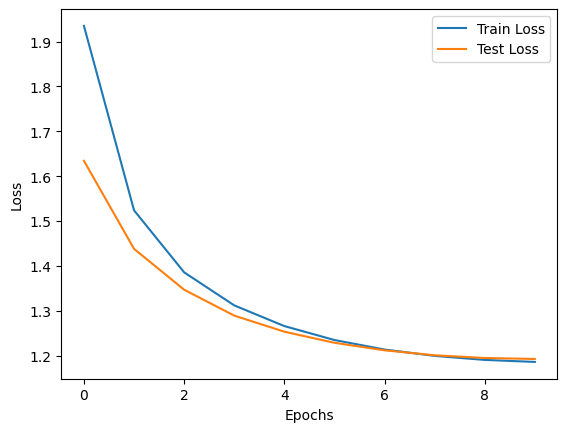

In [ ]:
import matplotlib.pyplot as plt
# Suppose we logged train_accs, test_accs, train_losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

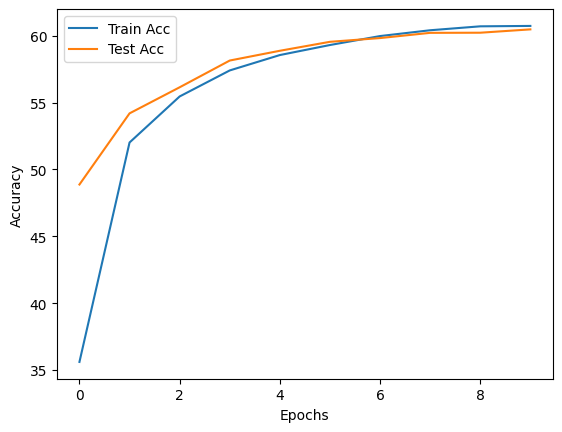

In [ ]:
import matplotlib.pyplot as plt

# Suppose we logged train_accs, test_accs, train_losses
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
